In [34]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import label_binarize
from transformers import RobertaModel, RobertaTokenizer

In [35]:
# Khởi tạo model RoBERTa + LSTM
class RoBERTa_LSTM(nn.Module):
    def __init__(self, roberta_model_name="roberta-base", lstm_hidden_size=128, num_labels=4):
        super(RoBERTa_LSTM, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_size * 2, num_labels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        lstm_input = roberta_output.last_hidden_state
        lstm_output, _ = self.lstm(lstm_input)
        lstm_output = self.dropout(lstm_output[:, -1, :])
        output = self.fc(lstm_output)
        return output

In [36]:
# --- Khởi tạo thiết bị ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Khởi tạo model và tokenizer ---
model = RoBERTa_LSTM()
# Load trọng số (đường dẫn thay thế nếu cần)
model.load_state_dict(torch.load("model/roberta_lstm_model.pth", map_location=device))
model.to(device)
model.eval()

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\DELL\AppData\Local\Temp\ipykernel_19360\3697719400.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

In [37]:

# ---------- TẠO DATA TEST GIẢ (nếu không có tập test) ----------
# 10 câu giả và nhãn thật tương ứng [0-3]
texts_test = [
    "This study explores new algorithms for machine learning optimization.",
    "A novel method for enhancing solar panel efficiency is presented.",
    "The proposed technique reduces energy consumption in smart grids.",
    "Deep learning has been applied to improve medical image analysis.",
    "A fast and accurate method for DNA sequencing is introduced.",
    "We developed a new blockchain protocol for secure transactions.",
    "Robotics and automation are revolutionizing manufacturing industries.",
    "Quantum computing offers advantages in cryptography applications.",
    "AI-driven models enhance real-time traffic prediction systems.",
    "New wireless technologies improve IoT device connectivity.",
    "This is an INIT-type sentence.",       # label 0
    "GEN-type generation is described.",    # label 1
    "This paragraph was POLISHED.",         # label 2
    "FUSION of ideas is evident here."     # label 3
]

In [38]:
labels_test = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 0, 1, 2, 3]

In [39]:
class_names = ["INIT", "GEN", "POLISH", "FUSION"]

In [40]:
# --- Tokenize dữ liệu ---
encoded_inputs = tokenizer(texts_test, padding=True, truncation=True, max_length=128, return_tensors="pt")
input_ids = encoded_inputs["input_ids"].to(device)
attention_mask = encoded_inputs["attention_mask"].to(device)

In [41]:
# --- Dự đoán ---
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    all_probs = torch.softmax(outputs, dim=1).cpu().numpy()
    pred_labels = np.argmax(all_probs, axis=1)

print("Predicted labels:", pred_labels)

# --- Accuracy tổng thể ---
acc_overall = accuracy_score(labels_test, pred_labels)
print(f"Overall Accuracy: {acc_overall:.4f}")

Predicted labels: [2 2 2 2 0 0 2 2 2 2 0 0 0 0]
Overall Accuracy: 0.2857


In [42]:
# --- Accuracy từng lớp ---
for cls in range(4):
    idx = [i for i, label in enumerate(labels_test) if label == cls]
    true_labels_cls = [labels_test[i] for i in idx]
    pred_labels_cls = [pred_labels[i] for i in idx]
    acc_cls = accuracy_score(true_labels_cls, pred_labels_cls)
    print(f"Accuracy for class {cls} ({class_names[cls]}): {acc_cls:.4f}")

# --- One-hot encode nhãn để vẽ ROC ---
labels_bin = label_binarize(labels_test, classes=[0,1,2,3])

Accuracy for class 0 (INIT): 0.5000
Accuracy for class 1 (GEN): 0.0000
Accuracy for class 2 (POLISH): 0.6667
Accuracy for class 3 (FUSION): 0.0000


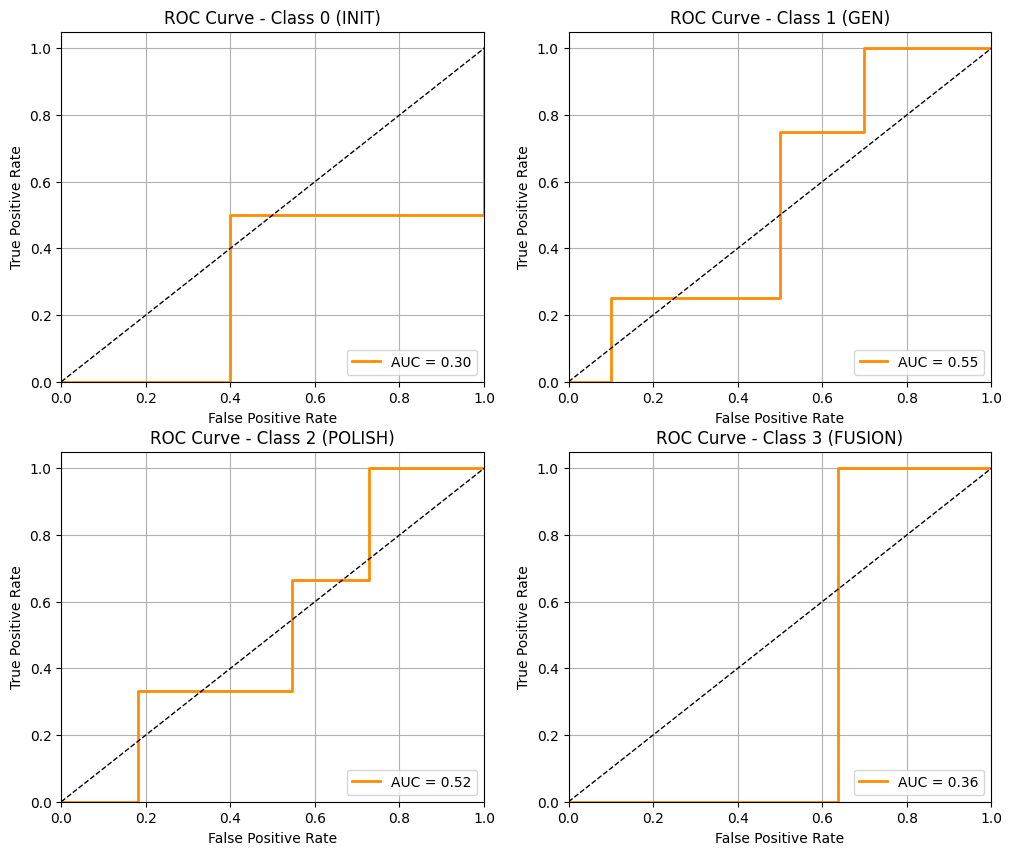

In [43]:
# --- Vẽ ROC Curve ---
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i in range(4):
    try:
        fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
        auc = roc_auc_score(labels_bin[:, i], all_probs[:, i])
    except ValueError:
        print(f"Cannot calculate ROC/AUC for class {i} ({class_names[i]}), probably due to lack of positive samples.")
        fpr, tpr, auc = [0,1], [0,1], 0.5
    
    axs[i].plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='darkorange', lw=2)
    axs[i].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].set_title(f"ROC Curve - Class {i} ({class_names[i]})")
    axs[i].legend(loc="lower right")
    axs[i].grid(True)

<Figure size 640x480 with 0 Axes>

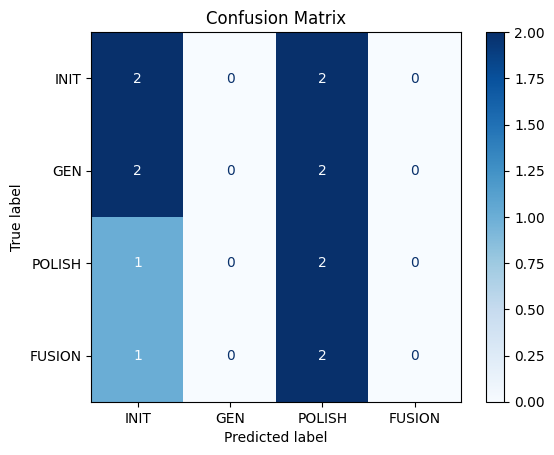

In [44]:
plt.tight_layout()
plt.savefig("roc_auc_4_classes.png")
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(labels_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

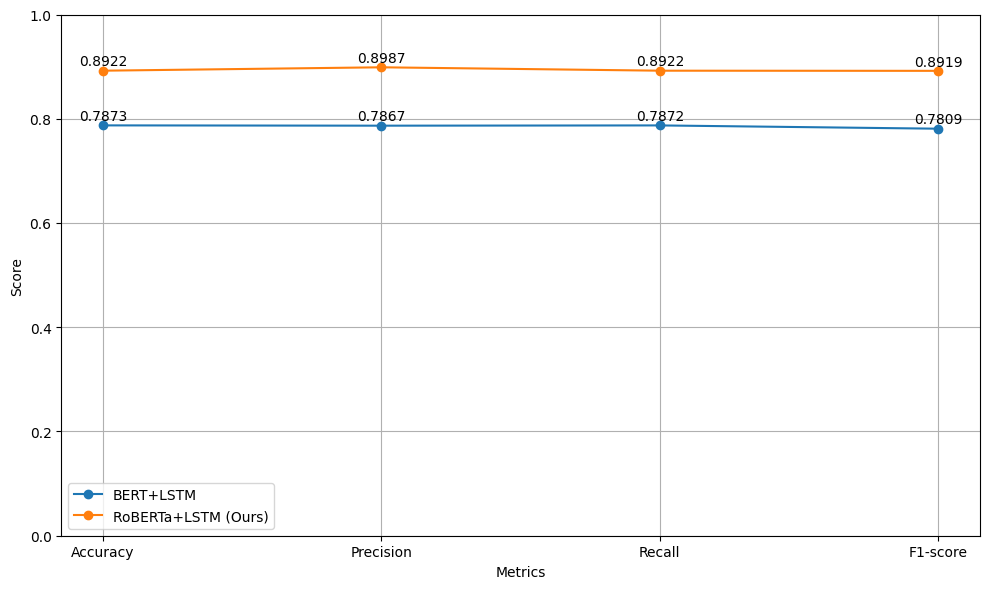

In [47]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
bert_lstm = [0.78727, 0.7867, 0.7872, 0.7809]
roberta_lstm = [0.8922, 0.8987, 0.8922, 0.8919]

x = np.arange(len(metrics))

plt.figure(figsize=(10,6))
plt.plot(x, bert_lstm, marker='o', label='BERT+LSTM')
plt.plot(x, roberta_lstm, marker='o', label='RoBERTa+LSTM (Ours)')

plt.xticks(x, metrics)
plt.ylim(0,1)
plt.xlabel('Metrics')
plt.ylabel('Score')
# plt.title('So sánh các chỉ số hiệu suất của 2 mô hình')
plt.grid(True)
plt.legend()

# Ghi giá trị điểm lên từng điểm trên đường
for i, v in enumerate(bert_lstm):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
for i, v in enumerate(roberta_lstm):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()


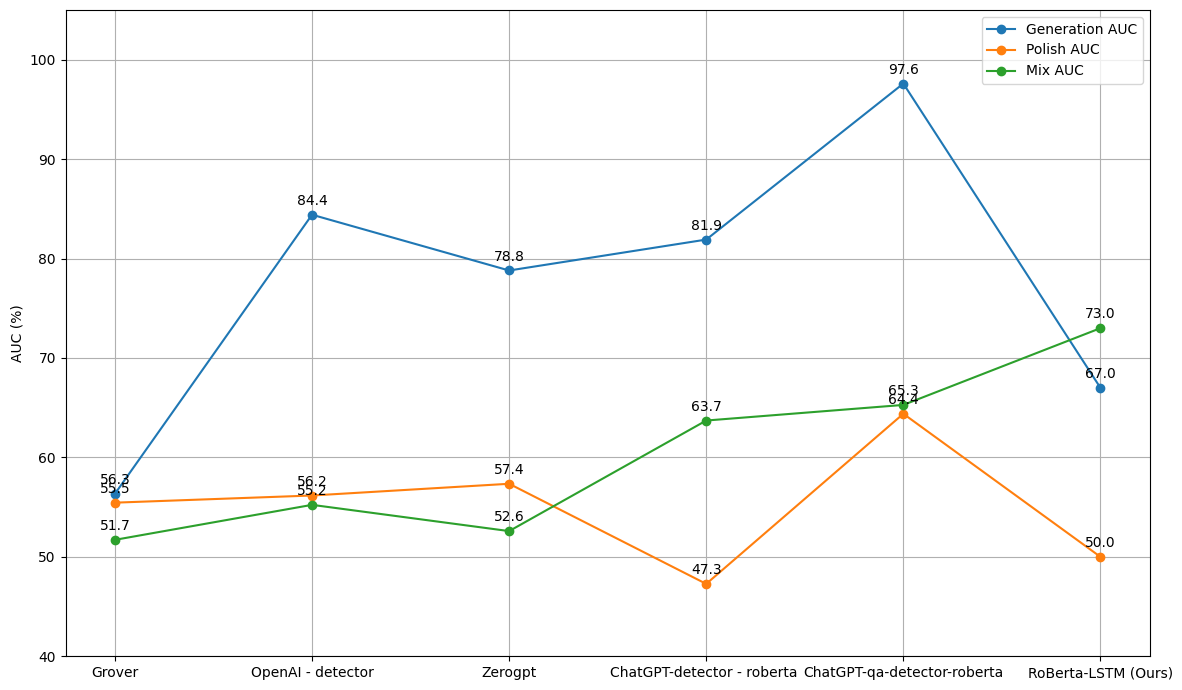

In [56]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "Grover",
    "OpenAI - detector",
    "Zerogpt",
    "ChatGPT-detector - roberta ",
    "ChatGPT-qa-detector-roberta",
    "RoBerta-LSTM (Ours)"
]

auc_generation = [56.34, 84.41, 78.8, 81.91, 97.6, 67.0]
auc_polish = [55.45, 56.17, 57.35, 47.28, 64.39, 50.0]
auc_mix = [51.71, 55.23, 52.59, 63.71, 65.28, 73.0]

x = np.arange(len(methods))

plt.figure(figsize=(12, 7))
plt.plot(x, auc_generation, marker='o', label='Generation AUC')
plt.plot(x, auc_polish, marker='o', label='Polish AUC')
plt.plot(x, auc_mix, marker='o', label='Mix AUC')

plt.xticks(x, methods, rotation=0, ha='center')  # Chữ nằm thẳng và căn giữa
plt.ylim(40, 105)
plt.ylabel('AUC (%)')
plt.grid(True)
plt.legend()

# Ghi giá trị AUC lên từng điểm
for i in range(len(methods)):
    plt.text(x[i], auc_generation[i]+1, f"{auc_generation[i]:.1f}", ha='center')
    plt.text(x[i], auc_polish[i]+1, f"{auc_polish[i]:.1f}", ha='center')
    plt.text(x[i], auc_mix[i]+1, f"{auc_mix[i]:.1f}", ha='center')

plt.tight_layout()
plt.show()


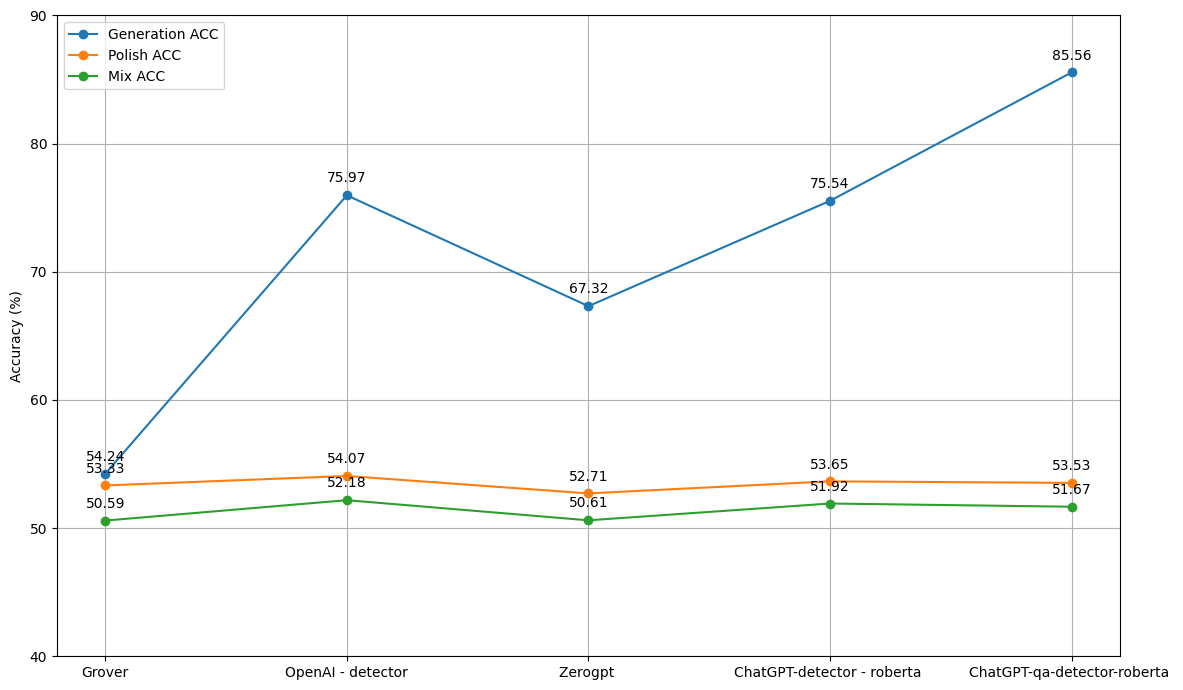

In [57]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "Grover",
    "OpenAI - detector",
    "Zerogpt ",
    "ChatGPT-detector - roberta ",
    "ChatGPT-qa-detector-roberta "
]

acc_generation = [54.24, 75.97, 67.32, 75.54, 85.56]
acc_polish = [53.33, 54.07, 52.71, 53.65, 53.53]
acc_mix = [50.59, 52.18, 50.61, 51.92, 51.67]

x = np.arange(len(methods))

plt.figure(figsize=(12, 7))
plt.plot(x, acc_generation, marker='o', label='Generation ACC')
plt.plot(x, acc_polish, marker='o', label='Polish ACC')
plt.plot(x, acc_mix, marker='o', label='Mix ACC')

plt.xticks(x, methods, rotation=0, ha='center')  # Chữ nằm thẳng và căn giữa
plt.ylim(40, 90)
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Ghi giá trị ACC lên từng điểm
for i in range(len(methods)):
    plt.text(x[i], acc_generation[i]+1, f"{acc_generation[i]:.2f}", ha='center')
    plt.text(x[i], acc_polish[i]+1, f"{acc_polish[i]:.2f}", ha='center')
    plt.text(x[i], acc_mix[i]+1, f"{acc_mix[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()
